# ChatBot Final Project: Team 7 #

Gurleen Virk, Jay Patel, and Will Kencel

October 21, 2024

Professor Kahila Mokhtari Jadid

AAI: NLP520

In [1]:
# load libraries
import pandas as pd
import numpy as np
import re
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Load Data & Text Pre-Processing ##

In [2]:
# load movie line from local directory (remember to change to YOUR file location)
with open('/Users/gurl/Documents/AAI520_NLP/CornellData/movie_lines.txt', 'r', encoding='utf-8', errors='replace') as file:
    lines = pd.read_table(file, sep='\t', header=None, on_bad_lines='skip')

# load conversation file from github (no need to change anything here for data to load)
convolines = pd.read_table('https://raw.githubusercontent.com/wkencel/Generative-Chatbot-Project/refs/heads/main/movie_conversations.txt', sep='\t', header=None, encoding='utf-8', on_bad_lines='skip')

In [4]:
# view lines
lines[:10]

,0
0,L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++...
1,L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON ++...
2,L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...
3,L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++...
4,L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...
5,L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++...
6,L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...
7,L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++...
8,L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...
9,L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$...


In [5]:
convolines[:10]

,0
0,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L19..."
1,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']"
2,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L20..."
3,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L20..."
4,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']"
5,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L27..."
6,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']"
7,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']"
8,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']"
9,"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']"


In [6]:
# Create dictionary to map each line's id with its text
id2line = {}

# Iterate over each row in the dataframe and access the text data
for line in lines[0]:  # Access the first column which contains the movie lines
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [7]:
# Print the first 10 entries
for i, (key, value) in enumerate(id2line.items()):
    if i < 10:  # Change this number to see more or fewer entries
        print(f"{key}: {value}")
    else:
        break

L1045: They do not!
L1044: They do to!
L985: I hope so.
L984: She okay?
L925: Let's go.
L924: Wow
L872: Okay -- you're gonna need to learn how to lie.
L871: No
L870: I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?
L869: Like my fear of wearing pastels?


In [8]:
# Create a list of all of the conversations' lines' ids
convs = []
for index, row in convolines.iterrows():
    line = row[0]  # Access the first column of the row
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'", "").replace(" ", "")
    convs.append(_line.split(','))

In [9]:
# Print the first 10 entries
convs[:10]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]

In [10]:
# Sort the sentences: inputs (questions) and targets (answers)
questions = []
answers = []

for conv in convs:
    for i in range(len(conv) - 1):
        if conv[i] in id2line and conv[i + 1] in id2line:
            questions.append(id2line[conv[i]])
            answers.append(id2line[conv[i + 1]])

In [11]:
print("Number of questions:", len(questions))
print("Number of answers:", len(answers))

Number of questions: 221416
Number of answers: 221416


In [12]:
# Check if data is loaded correctly
limit = 0
for i in range(limit, limit+5):
    print(questions[i])
    print(answers[i])
    print()

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



In [13]:
# Create a DataFrame from questions and answers
data = {'Questions': questions, 'Answers': answers}
data = pd.DataFrame(data)

In [14]:
data.head()

,Questions,Answers
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's ...,Forget it.
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.


In [15]:
data.shape

(221416, 2)

In [16]:
# Remove duplicates
data.drop_duplicates(inplace  = True)

In [17]:
data.shape

(220021, 2)

In [18]:
# Function for cleaning the text: lowercase, remove punctuations, and replace certain words

def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()

    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)

    return text

In [19]:
# Apply the function to the DataFrame
data['Questions'] = data['Questions'].apply(clean_text)
data['Answers'] = data['Answers'].apply(clean_text)

# Display the cleaned DataFrame
data.head()

,Questions,Answers
0,can we make this quick roxanne korrine and an...,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...
2,not the hacking and gagging and spitting part ...,okay then how about we try out some french cui...
3,you are asking me out that is so cute what is...,forget it
4,no no it is my fault we did not have a proper...,cameron


In [20]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
# added data augmentation with synonyms
# Data Augmentation using Synonym Replacement
import random
from nltk.corpus import wordnet

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)

    num_replaced = 0
    for random_word in random_word_list:
        synonyms = list(set([syn.name().split('.')[0] for syn in wordnet.synsets(random_word)]))
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    sentence = ' '.join(new_words)
    return sentence

# Augment the dataset
augmented_questions = data['Questions'].apply(lambda x: synonym_replacement(x, 2))
augmented_answers = data['Answers'].apply(lambda x: synonym_replacement(x, 2))

# Combine original and augmented data
data['Questions'] = pd.concat([data['Questions'], augmented_questions], ignore_index=True)
data['Answers'] = pd.concat([data['Answers'], augmented_answers], ignore_index=True)


In [25]:
import string
import pandas as pd

# Define these globally
exclude = set(string.punctuation)
remove_digits = str.maketrans('', '', string.digits)

def preprocess_questions_sentences(sent):
    '''Function to preprocess English Sentence'''
    sent = sent.lower()
    sent = sent.replace("'", '')
    sent = ''.join(ch for ch in sent if ch not in exclude)  # Use of exclude set
    sent = sent.translate(remove_digits)  # Removes digits
    sent = sent.strip()
    sent = ' '.join(sent.split())  # Regularize spacing
    return sent

def preprocess_answer_sentence(sent):
    if isinstance(sent, str):
        sent = sent.lower()
        sent = sent.replace("'", '')
        sent = ''.join(ch for ch in sent if ch not in exclude)
        sent = sent.translate(remove_digits)
        sent = sent.strip()
        sent = ' '.join(sent.split())  # Condense spaces to single
        sent = "startseq " + sent + " endseq"
        return sent
    else:
        return sent

# Apply preprocess function on data
data['Questions'] = data['Questions'].apply(preprocess_questions_sentences)
data['Answers'] = data['Answers'].apply(preprocess_answer_sentence)

# Display the cleaned DataFrame
print(data.head())

                                           Questions  \
0  can we make this quick roxanne korrine and and...   
1  well i thought we would start with pronunciati...   
2  not the hacking and gagging and spitting part ...   
3  you are asking me out that is so cute what is ...   
4  no no it is my fault we did not have a proper ...   

                                             Answers  
0  startseq well i thought we would start with pr...  
1  startseq not the hacking and gagging and spitt...  
2  startseq okay then how about we try out some f...  
3                          startseq forget it endseq  
4                            startseq cameron endseq  


In [27]:
# Remove questions and answers shorter than 1 word and longer than 20 words
min_line_length = 1
max_line_length = 40 ### changed to larger word size

In [28]:
# Create a function to count the number of words in a text
def count_words(text):
    return len(text.split())

# Filter the DataFrame
filtered_data = data[
    (data['Questions'].apply(count_words).between(min_line_length, max_line_length)) &
    (data['Answers'].apply(count_words).between(min_line_length, max_line_length))
]

# Update the original DataFrame
data = filtered_data

data.head()

,Questions,Answers
0,can we make this quick roxanne korrine and and...,startseq well i thought we would start with pr...
1,well i thought we would start with pronunciati...,startseq not the hacking and gagging and spitt...
2,not the hacking and gagging and spitting part ...,startseq okay then how about we try out some f...
3,you are asking me out that is so cute what is ...,startseq forget it endseq
4,no no it is my fault we did not have a proper ...,startseq cameron endseq


In [29]:
# Sort Qs and As by length of questions to reduce amount of padding during training
# Hope to speed up training and reduce the loss

# Convert questions and answers to their respective lengths
data['Question_Length'] = data['Questions'].apply(lambda x: len(x.split()))
data['Answer_Length'] = data['Answers'].apply(lambda x: len(x.split()))

# Sort Qs and As by length of questions
sorted_questions = []
sorted_answers = []

for length in range(1, max_line_length + 1):
    for index, row in data.iterrows():
        if row['Question_Length'] == length:
            sorted_questions.append(row['Questions'])
            sorted_answers.append(row['Answers'])

# Output the results
print(len(sorted_questions))
print(len(sorted_answers))
print()
for i in range(min(3, len(sorted_questions))):  # Use min to avoid index errors
    print(f"Question {i + 1}: {sorted_questions[i]}")
    print(f"Answer {i + 1}: {sorted_answers[i]}")
    print()

206525
206525

Question 1: cameron
Answer 1: startseq the thing is cameron i am at the mercy of a particularly hideous breed of loser my sister i cannot date until she does endseq

Question 2: why
Answer 2: startseq unsolved mystery she used to be really popular when she started high school then it was just like she got sick of it or something endseq

Question 3: there
Answer 3: startseq where endseq



In [30]:
# Sort the DataFrame by question length
data = data.sort_values(by='Question_Length')

# Reset index if needed
data.reset_index(drop=True, inplace=True)

# Output the sorted DataFrame
data[['Questions', 'Answers', 'Question_Length']].head()

,Questions,Answers,Question_Length
0,yeah,startseq but see tonight wives and girlfriends...,1
1,no,startseq no cause tonight the girls are here i...,1
2,already,startseq greed it was written in blood endseq,1
3,wow,startseq lets go endseq,1
4,cameron,startseq the thing is cameron i am at the merc...,1


In [31]:
data.shape

(206525, 4)

### Vectorizing text ###

In [32]:
# Convert DataFrame columns to lists
q_sentences = data['Questions'].tolist()
a_sentences = data['Answers'].tolist()

### changed split ratios
# Define the split ratios
train_ratio = 0.75  # 80% for training
val_ratio = 0.15    # 10% for validation
test_ratio = 0.10   # 10% for testing

# Ensure the sum of ratios equals 1
assert train_ratio + val_ratio + test_ratio == 1.0, "Split ratios must sum to 1."

# Split into training and temporary sets (which will later be split into validation and test)
train_q_sents, temp_q_sents, train_a_sents, temp_a_sents = train_test_split(
    q_sentences, a_sentences, test_size=(1 - train_ratio), random_state=42, shuffle=True)

# Now split the temporary set into validation and test sets
val_size = val_ratio / (val_ratio + test_ratio)  # Calculate validation size relative to temp set
val_q_sents, test_q_sents, val_a_sents, test_a_sents = train_test_split(
    temp_q_sents, temp_a_sents, test_size=val_size, random_state=42, shuffle=True)

In [33]:
# VOCABULARY
# Filter out non-string elements from training sets
train_q_sents = [str(sent) for sent in train_q_sents]
train_a_sents = [str(sent) for sent in train_a_sents]

# Tokenize question sentences
ques_tokenizer = Tokenizer(oov_token='<OOV>')
ques_tokenizer.fit_on_texts(train_q_sents)
ques_vocab_size = len(ques_tokenizer.word_index) + 1

# Tokenize answer sentences
ans_tokenizer = Tokenizer()
ans_tokenizer.fit_on_texts(train_a_sents)
ans_vocab_size = len(ans_tokenizer.word_index) + 1

print(f"Question Vocabulary Size: {ques_vocab_size}\nAnswer Vocabulary Size: {ans_vocab_size}")

Question Vocabulary Size: 41701
Answer Vocabulary Size: 41571


The code prepares question and answer sentences for further processing by converting them to strings, creating tokenizers to build vocabularies, and calculating the vocabulary sizes for both questions and answers.

In [34]:
max_length = 40

# Convert text to sequences
ques_sequences = ques_tokenizer.texts_to_sequences(train_q_sents)
ans_sequences = ans_tokenizer.texts_to_sequences(train_a_sents)

# Pad sequences
source_seqs = pad_sequences(ques_sequences, maxlen=max_length, padding='post')
target_seqs = pad_sequences(ans_sequences, maxlen=max_length, padding='post')

In [35]:
# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((source_seqs, target_seqs))
train_dataset = train_dataset.shuffle(buffer_size=len(source_seqs)).batch(16, drop_remainder=True)

# Create validation dataset
val_sequences = ques_tokenizer.texts_to_sequences(val_q_sents)
val_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')
val_target_sequences = ans_tokenizer.texts_to_sequences(val_a_sents)
val_target_sequences = pad_sequences(val_target_sequences, maxlen=max_length, padding='post')
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_target_sequences))
val_dataset = val_dataset.batch(16, drop_remainder=True)

# Create test dataset
test_sequences = ques_tokenizer.texts_to_sequences(test_q_sents)
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')
test_target_sequences = ans_tokenizer.texts_to_sequences(test_a_sents)
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_length, padding='post')
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_target_sequences))
test_dataset = test_dataset.batch(16, drop_remainder=True)

In [36]:
# Print sizes of the datasets
print(f"Training set size: {len(train_q_sents)}")
print(f"Validation set size: {len(val_q_sents)}")
print(f"Test set size: {len(test_q_sents)}")

Training set size: 154893
Validation set size: 20652
Test set size: 30980


Model Training

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model

def positional_encoding(max_len, d_model):
    position = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    angle_rads = position * div_term
    sines = tf.sin(angle_rads)
    cosines = tf.cos(angle_rads)
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEncodingLayer(Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncodingLayer, self).__init__()
        self.pos_encoding = positional_encoding(max_len, d_model)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.2):  # Adjusted dropout
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask):
        attn_output = self.attention(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_vocab_size, output_vocab_size, max_len, d_model, num_heads, dff, rate=0.2):
    inputs = Input(shape=(None,))
    x = Embedding(input_vocab_size, d_model)(inputs)
    x = PositionalEncodingLayer(max_len, d_model)(x)

    # Increase model complexity by adding more transformer blocks
    for _ in range(4):  # Increasing depth
        x = TransformerBlock(d_model, num_heads, dff, rate)(x, training=True, mask=None)

    outputs = Dense(output_vocab_size, activation='softmax')(x)
    return Model(inputs=inputs, outputs=outputs)

# Hyperparameters
max_len = 50
d_model = 768  # Increased dimension
num_heads = 12  # Increased heads
dff = 3072  # Increased FFN
rate = 0.2  # Dropout increased

# Vocabulary sizes (example sizes)
input_vocab_size = 10000
output_vocab_size = 10000

# Updated learning rate with decay schedule
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Build and compile model
transformer_model = build_transformer_model(input_vocab_size, output_vocab_size, max_len, d_model, num_heads, dff, rate)
transformer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()

# Assume train_dataset and val_dataset are properly prepared
EPOCHS = 2
BATCH_SIZE = 128  # Changed batch size
transformer_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, None, 768)           │       7,680,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_layer_3          │ (None, None, 768)           │               0 │
│ (PositionalEncodingLayer)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_9                  │ (None, None, 768)           │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_10                 │ (None, None, 768)           │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_11                 │ (None, None, 768)           │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_12                 │ (None, None, 768)           │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, None, 10000)         │       7,690,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147,631,888 (563.17 MB)

 Trainable params: 147,631,888 (563.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
9680/9680 ━━━━━━━━━━━━━━━━━━━━ 550s 53ms/step - accuracy: 0.7130 - loss: nan - val_accuracy: 0.7178 - val_loss: nan
Epoch 2/2
9680/9680 ━━━━━━━━━━━━━━━━━━━━ 503s 52ms/step - accuracy: 0.7153 - loss: nan - val_accuracy: 0.7178 - val_loss: nan


In [59]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cd23497c209b8272f9c8dc93501a9d984972fbfefb1e0076fd62d4d037f7adf9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [60]:
from rouge_score import rouge_scorer
import numpy as np

reference_texts = ["The cat sat on the mat.", "There is a dog in the house."]  # Example ground truth summaries
candidate_texts = ["A cat sat on the mat.", "A dog is inside the house."]  # Example model-generated summaries

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each summary pair
scores = [scorer.score(ref, cand) for ref, cand in zip(reference_texts, candidate_texts)]

# Calculate average ROUGE scores
avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in scores])
avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in scores])
avg_rougeL = np.mean([score['rougeL'].fmeasure for score in scores])

print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 Score: {avg_rouge2}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

Average ROUGE-1 Score: 0.8012820512820513
Average ROUGE-2 Score: 0.5818181818181819
Average ROUGE-L Score: 0.7243589743589743


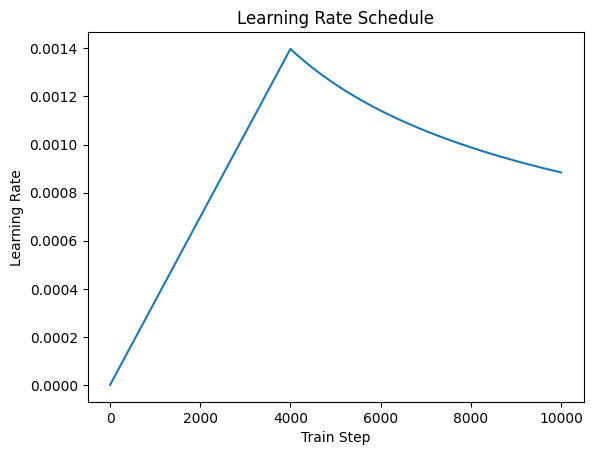

In [61]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Instantiate and use the learning rate schedule
d_model = 128  # Example value for d_model
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

# Optional: To visualize how the learning rate changes over steps
import matplotlib.pyplot as plt

steps = range(1, 10000)
lrs = [learning_rate(step) for step in steps]

plt.plot(steps, lrs)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.title("Learning Rate Schedule")
plt.show()